# Fitting a line to GRB afterglow photometry

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    a broken powerlaw is a prefer model for the GRB afterglow.
    

# initial imports

In [3]:
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
%pylab inline



Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset

In [4]:
grbAG = pd.read_csv("grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [5]:
grbAG.tail()

,filter,time,mag,magerr,upperlimit
114,W1,63738,21.20,NaN,1
115,M2,74798,21.59,NaN,1
116,U,128928,20.05,NaN,1
117,V,971360,22.09,NaN,1
118,V,1171176,21.16,NaN,1


In [18]:
grbAG.describe()

,time,mag,magerr,upperlimit,logtime
count,1.190000e+02,119.000000,108.000000,119.000000,119.000000
mean,2.767789e+04,16.239282,0.188981,0.092437,3.053020
std,1.391231e+05,2.506169,0.088676,0.290867,1.006545
min,6.600000e+01,12.860000,0.060000,0.000000,1.819544
25%,2.085000e+02,14.340842,0.120000,0.000000,2.318895
50%,6.240000e+02,15.780000,0.180000,0.000000,2.795185
75%,6.372500e+03,17.883091,0.230000,0.000000,3.803501
max,1.171176e+06,22.090000,0.540000,1.000000,6.068622


In [19]:
grbAG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filter      119 non-null    object 
 1   time        119 non-null    int64  
 2   mag         119 non-null    float64
 3   magerr      108 non-null    float64
 4   upperlimit  119 non-null    int64  
 5   logtime     119 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 5.7+ KB


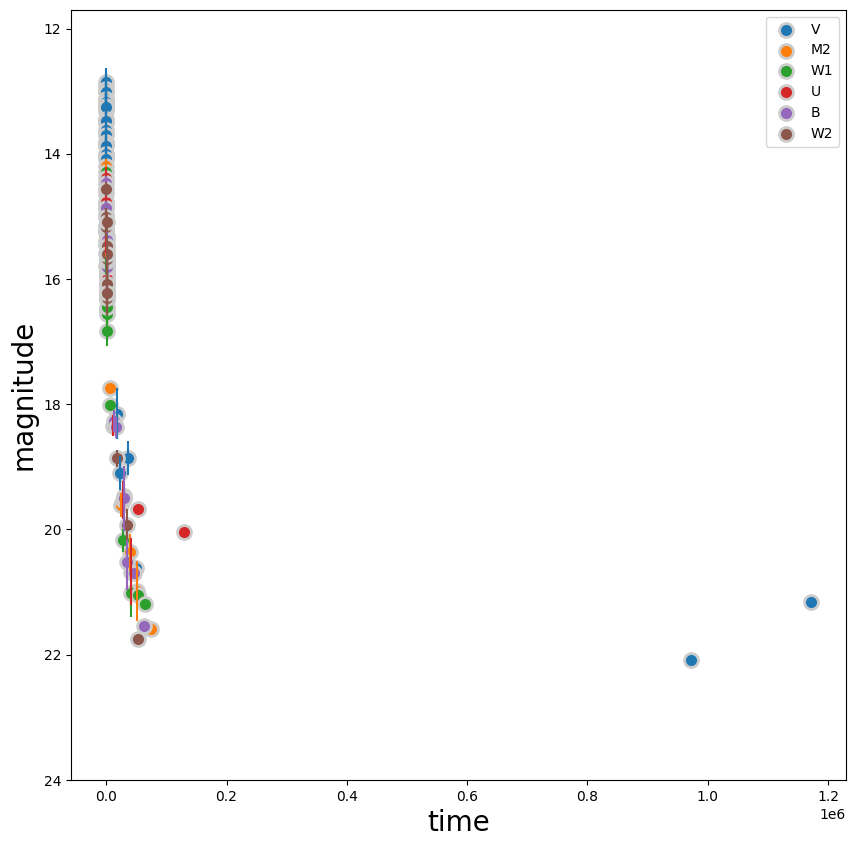

In [6]:
# create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

# loop on every filter to plot - this will give differnt colors naturally.
# Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].magerr, 0, 2,
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

# Always rememeber axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [7]:
grbAG['logtime'] = np.log10(grbAG['time'])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Here we plot the data with different colors for different photometric bands.

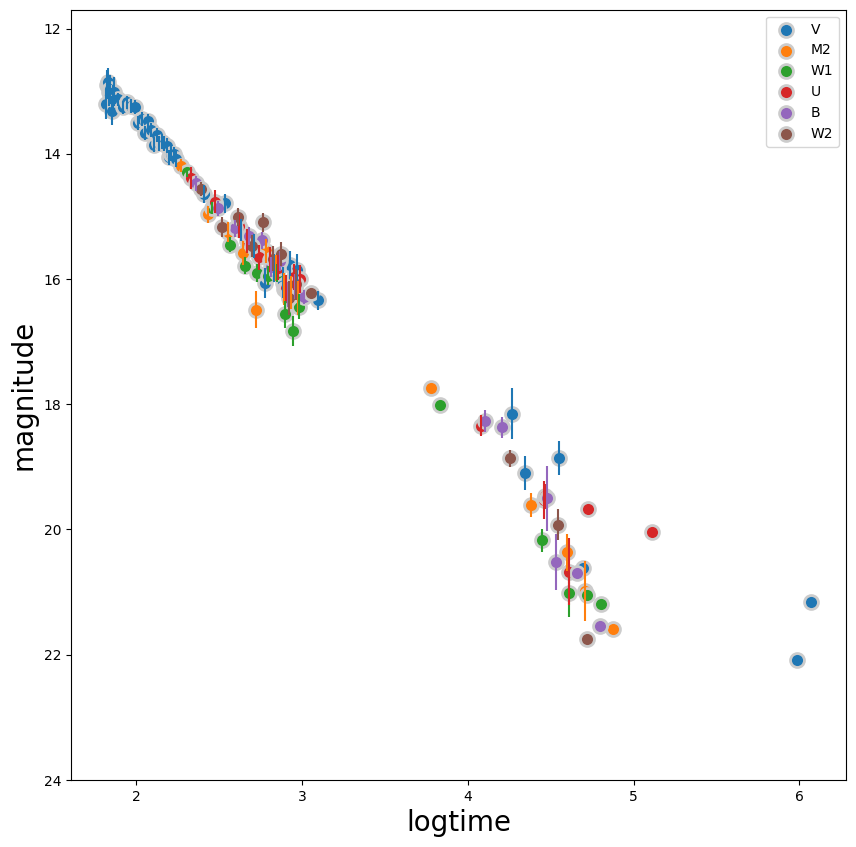

In [8]:
# create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

# loop on every filter to plot - this will give differnt colors naturally.
# Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].magerr, 0, 2,
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

# Always rememeber axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("logtime", fontsize=20);

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: slope and intercept. Therefore the input has to be Nx2


In [9]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)

shape of the input array X (108, 2)
shape of the input array y (108,)


In [10]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

In [11]:
data = grbAG.loc[grbAG.upperlimit == 0]

X = data[['logtime']]
y = data['mag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% of the data will be used for testing

lr = LinearRegression().fit(X_train, y_train)

intercept = lr.intercept_
slope = lr.coef_[0]

print(f'Intercept: {intercept:.2f}')
print(f'Slope: {slope:.2f}')

train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

print(f'Training R^2 Score: {train_score:.2f}')
print(f'Test R^2 Score: {test_score:.2f}')

Intercept: 8.65
Slope: 2.49
Training R^2 Score: 0.97
Test R^2 Score: 0.97


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, L1 and L2 metric as the objective function.

In [12]:
minimize?

In [13]:

def line(params, x):
    intercept, slope = params
    return slope * x + intercept

def l1(params, x, y):
    model_values = line(params, x)
    return sum(abs(model_values - y))


initialGuess = [10,2]

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 26.303331246680866
        x: [ 8.225e+00  2.641e+00]
      nit: 15
      jac: [ 0.000e+00 -7.153e-07]
 hess_inv: [[ 2.678e-05 -5.406e-06]
            [-5.406e-06  5.521e-06]]
     nfev: 156
     njev: 52

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [14]:

def l2(params, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    params: (array) model parameters [intercept, slope]
    x: the exogenous variable (array)
    y: the endogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    model_values = line(params, x)
    return sum((model_values - y) ** 2)


x = data['logtime'].values
y = data['mag'].values

initialGuess = [10, 2]

l2Solution = minimize(l2, initialGuess, args=(x, y))

print(l2Solution)
print("\n")
print("best fit parameters from the minimization of L2: " +
      "intercept {:.2f}, slope {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500725411
        x: [ 8.583e+00  2.512e+00]
      nit: 4
      jac: [ 0.000e+00  2.384e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 18
     njev: 6


best fit parameters from the minimization of L2: intercept 8.58, slope 2.51



# account for the measurements uncertainties

Since the data has uncertainty,  $\chi^2$ (chi squared) function as objective function

In [16]:
def chi2(params, x, y, s):
    '''chi2 target function: returns value of chi2 for given arguments and data for a line model
    params: (array) model parameters [intercept, slope]
    x: the exogenous variable (array)
    y: the endogenous variable (array)
    s: uncertainties associated with y
    returns chi2 sum of squared difference between prediction and data normalized by uncertainties
    '''
    model_values = line(params, x)
    return sum(((y - model_values) / s) ** 2)


x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = [8, 2]

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.4206698013055
        x: [ 8.599e+00  2.480e+00]
      nit: 5
      jac: [ 7.629e-06  1.030e-04]
 hess_inv: [[ 1.559e-03 -5.429e-04]
            [-5.429e-04  2.017e-04]]
     nfev: 90
     njev: 26

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


# Plot all the solutions

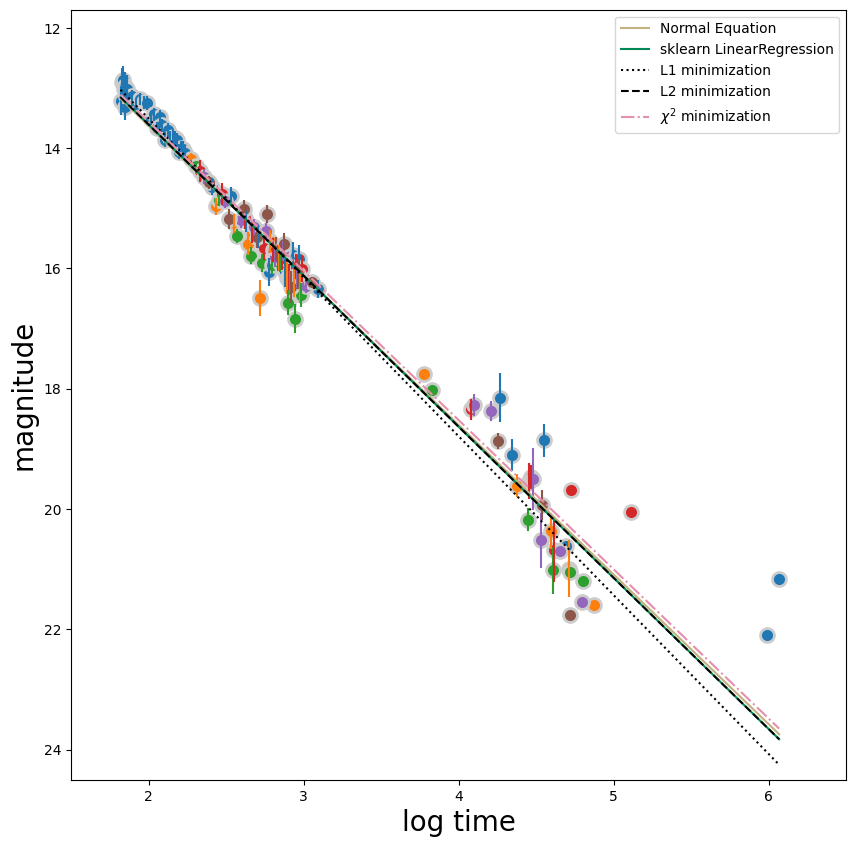

In [17]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line((intercept, slope), x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = pl.figure(figsize=(10,10)).add_subplot(111)

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)

for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               edgecolor='#cccccc', label=None)


nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].magerr, 0, 2,
            head_width=0.05, head_length=0.1, ec='k')

colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

plotline((lr.coef_[0], lr.intercept_), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

plotline((theta_best[::-1]), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)

plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)

plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.